In [82]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import KNNImputer
import scipy.stats as stats
from sklearn.neighbors import KDTree
import pickle
from bioinfokit.analys import stat


from scipy.stats import skew 


warnings.filterwarnings("ignore") 
plt.style.use('seaborn-whitegrid') ###personal setting for the graphs



NB: Do not forget to change the years into age at the data of sale

# Plan

1. Identify the number and type of features 
    
2. Find the number/percentage of missing data for each feature 
    * visualize the results with a bar chart Identify the number and type of features 

3. Data distribution patterns
    * test the features and target variable for normalty 
    * plot them on histograms to visualize if they are normally distributed 
    * test transformations to achieve normal data 
    * visualize the results
    
4. Data correlations 
    * examine the correlation of each feature with the target variable 
    * examine the multicolinearity between features 
        * can also use pairplots 
    * suggests solutions to the challenges that are observed
    
5. Visualize dimension reductions 
    * segment the target Variable 
    * conduct PCA and visualize the results 
    * conduction TSNE analysis 

# Data Summary

1. Load the Data 
2. Identify initial dimensions 
3. Find missing variables for each feature and graph them - bar/scatter plot
5. find missing feature for each example and graph them - scartter plot

## Loading the data 

### Data Source: 
Kaggle
### Data Description:
Provided in the 'data_description.txt' file

In [21]:
# loading the data 

raw_df = pd.read_csv("train.csv")

print(f"The number of repeated data points are: {raw_df.shape[0] - len(set(raw_df.Id))}") # setting the Ids to ensure single counts only
raw_df.drop('Id', axis=1, inplace = True)
print(f"The number of features is: {raw_df.shape[1]}")
print(f"The number of instances is: {raw_df.shape[0]}")
print("\n\n")

print("The first 5 rows of the raw dataset:")
print("\n")
raw_df.head()

The number of repeated data points are: 0
The number of features is: 80
The number of instances is: 1460



The first 5 rows of the raw dataset:




,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Types

The data types of features informs how you can use, transform, interpret and treat the data. It is important to have an understand of how different data types are respresented in your dataset. Moreover, some features' data types may be wrongly assigned when loading the data using pandas. This is a common problem with categorical variables that are represented as numerical data. 

### Exploring the assigned data types

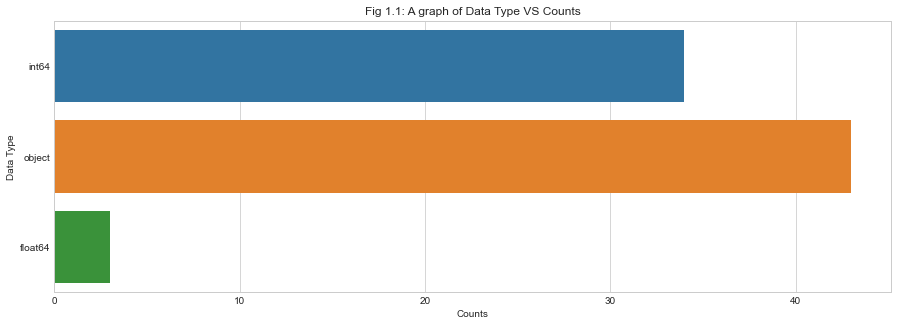

In [22]:
# inspecting the data types assigned when we uploaded the csv 

# visualizing the distribution of dtypes 
def visualize_dtypes(df, description):
    dtypes_list = []

    # calculating the counts of each feature
    for feature in df.columns:
        feature_dtype = df[feature].dtype.name
        dtypes_list.append(feature_dtype)

    fig,axes = plt.subplots(figsize=(15,5))
    axes = sns.countplot(y=dtypes_list)
    plt.xlabel('Counts')
    plt.ylabel('Data Type')
    plt.title(f'{description}')
    plt.show()
    
    return None

visualize_dtypes(raw_df, 'Fig 1.1: A graph of Data Type VS Counts')

It appears that pandas has assigned the 'int64' data type to nearly as many features as it did the 'object' data type. It is my preference to have the categorical and numeric data be labeled accordingly. This way, i can seperate the treatment of different features accordingly. Using the data description, i will inspect each feature's assigned data type and reassign it to my preference. 

In [23]:
# further inspection of data types assigned 
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

The assigned data types are not representative of the true type for some of the features. Reading metadata that contains a description of what each feature contains helped me identify the actual data types I would like to use. All features that contain continous variables will be converted to 'numeric' type and the rest will be converted to the 'category' type.

Certain features like 'GarageCars' and 'FullBath' were initially assigned the int type but they will be placed in the categorical data section because they are ordinal variables.

### Addressing dates 

Dates can be facinating to explore. However, foe the puporses of this analysis, we will convert them to age instead. All dates provided for when a feature or the house was built will be subtracted from the sale date. This will add to the number of numeric/continouse variables. We may miss trends such as a year when all houses experienced a boom, but this will be reserved for a time series analysis in my other projects. However, tranforming these days to age gives a better perspective overall about the houses being sold. 

In [24]:
# making new age columns and removeing the date columns 
dates_columns = ["YearBuilt", "YearRemodAdd","GarageYrBlt", "YrSold"]

raw_df["HouseAge"] = raw_df.YrSold - raw_df.YearBuilt
raw_df["RemodAge"] = raw_df.YrSold - raw_df.YearRemodAdd
raw_df["GarageAge"]=raw_df.YrSold - raw_df.GarageYrBlt

raw_df.drop(dates_columns, axis=1, inplace=True)

raw_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,HouseAge,RemodAge,GarageAge
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,WD,Normal,208500,5,5,5.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,WD,Normal,181500,31,31,31.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,WD,Normal,223500,7,6,7.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,WD,Abnorml,140000,91,36,8.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,WD,Normal,250000,8,8,8.0


### Reassigning data types 

As shown above, some assignments did not truely refelect the type of a variable they represent. Therefore, we will do a dtype reassignment to assist with further analysis approaches. 

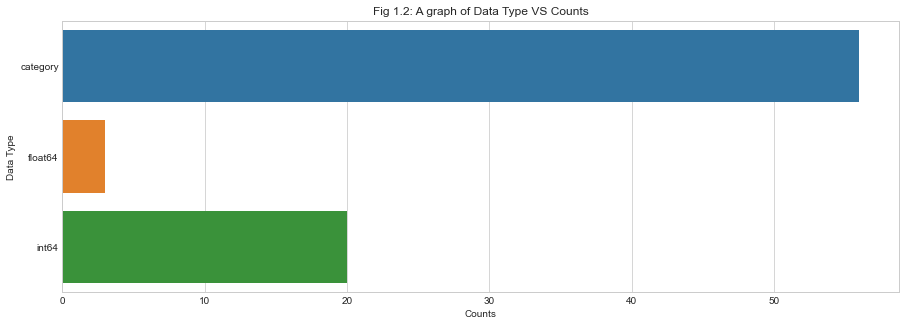

In [26]:
# Changing some default data types

feature_dtypes = {'MSSubClass':'category', 'MSZoning':'category', 'LotFrontage':'numeric', 'LotArea':'numeric', 'Street':'category',
       'Alley':'category', 'LotShape':'category', 'LandContour':'category', 'Utilities':'category', 'LotConfig':'category',
       'LandSlope':'category', 'Neighborhood':'category', 'Condition1':'category', 'Condition2':'category', 'BldgType':'category',
       'HouseStyle':'category', 'OverallQual':'category', 'OverallCond':'category', 'RoofStyle':'category', 'RoofMatl':'category', 
        'Exterior1st':'category','Exterior2nd':'category', 'MasVnrType':'category',
       'MasVnrArea':'numeric', 'ExterQual':'category', 'ExterCond':'category', 'Foundation':'category', 'BsmtQual':'category',
       'BsmtCond':'category', 'BsmtExposure':'category', 'BsmtFinType1':'category', 'BsmtFinSF1':'numeric',
       'BsmtFinType2':'category', 'BsmtFinSF2':'numeric', 'BsmtUnfSF':'numeric', 'TotalBsmtSF':'numeric', 'Heating':'category',
       'HeatingQC':'category', 'CentralAir':'category', 'Electrical':'category', '1stFlrSF':'numeric', '2ndFlrSF':'numeric',
       'LowQualFinSF':'numeric', 'GrLivArea':'numeric', 'BsmtFullBath':'category', 'BsmtHalfBath':'category', 'FullBath':'category',
       'HalfBath':'category', 'BedroomAbvGr':'category', 'KitchenAbvGr':'category', 'KitchenQual':'category',
       'TotRmsAbvGrd':'category', 'Functional':'category', 'Fireplaces':'category', 'FireplaceQu':'category', 'GarageType':'category',
       'GarageAge':'numeric', 'GarageFinish':'category', 'GarageCars':'category', 'GarageArea':'numeric', 'GarageQual':'category',
       'GarageCond':'category', 'PavedDrive':'category', 'WoodDeckSF':'numeric', 'OpenPorchSF':'numeric',
       'EnclosedPorch':'numeric', '3SsnPorch':'numeric', 'ScreenPorch':'numeric', 'PoolArea':'numeric', 'PoolQC':'category',
       'Fence':'category', 'MiscFeature':'category', 'MiscVal':'numeric', 'MoSold':'category', 'HouseAge':'numeric','RemodAge':'numeric', 'SaleType':'category',
       'SaleCondition':'category', 'SalePrice':'numeric'}


for feature, feature_dtype in feature_dtypes.items():
    if feature_dtype == "category":
        raw_df[f'{feature}'] = raw_df[f'{feature}'].astype(f'{feature_dtype}')
    else:
        raw_df[f'{feature}'] = pd.to_numeric(raw_df[f'{feature}'])

# visualise the new dtypes
visualize_dtypes(raw_df, 'Fig 1.2: A graph of Data Type VS Counts')

It appears that over 2/3 of our features are categorical. Several features denote the year some feature or house was built or sold. They were temporarily marked as categorical variables because they resemble ordinal data more than continous data. They will later be transformed into 'age' but subtracting them from the year the house was sold. 'Age' will be a continous varible. 

## Missing Data

Missing data is a problem that may affect the ultimate number of examples we have for modeling. The percentage of missing data influences how we will handle such data. If only a few examples are missing within a feature/column, then we may look at replacing them with the mean or most frequent value for that feature. 

If an instance/row has too many missing values across too many features/columns, we may want to delete it all together. This approach can be applied to features missing a significant number of values as well. For our puposes, features missing more than 10% of the data will be removed as well as examples missing more than 10% of their data.  

### Missing data per feature/column

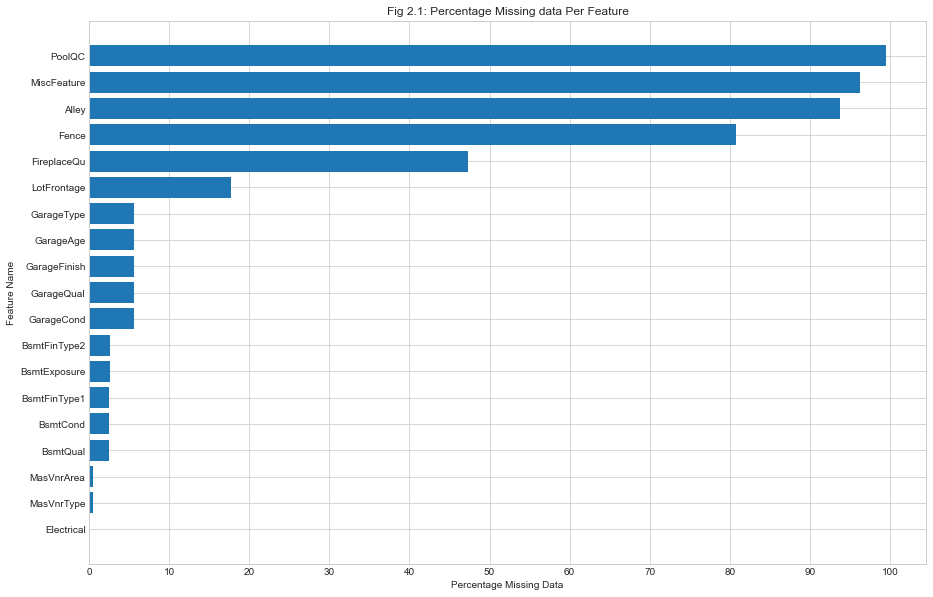

In [27]:
# missing values as a percentage of the data 

missing_data = (raw_df.isnull().sum()/raw_df.shape[0]) * 100
missing_data = missing_data[missing_data > 0]
missing_data.sort_values(ascending=True,inplace=True)

fig,axes = plt.subplots(figsize=(15,10))
axes = plt.barh(missing_data.index, width =np.array(missing_data) )
plt.xlabel('Percentage Missing Data')
plt.ylabel('Feature Name')
plt.xticks([x for x in range(0,110,10)])
plt.title('Fig 2.1: Percentage Missing data Per Feature')
plt.show()

The above graph shows that 6 features have more than 10% missing data. They will be eliminated from the data set before further explorations can be done. Another  12 features are missing about 5% or less of their data. It seems reasonable to impute values for the latter features and disregard the former. There is no missing data in the target variable. 

In [28]:
# removing columns with too many missing values 

raw_df.drop(missing_data[missing_data > 10].index, axis = 1, inplace = True)
print(f"The number of features is now: {raw_df.shape[1]}")
print(f"The number of instances is now : {raw_df.shape[0]}")
print("\n\n")

The number of features is now: 73
The number of instances is now : 1460





### Missing data per instance/row

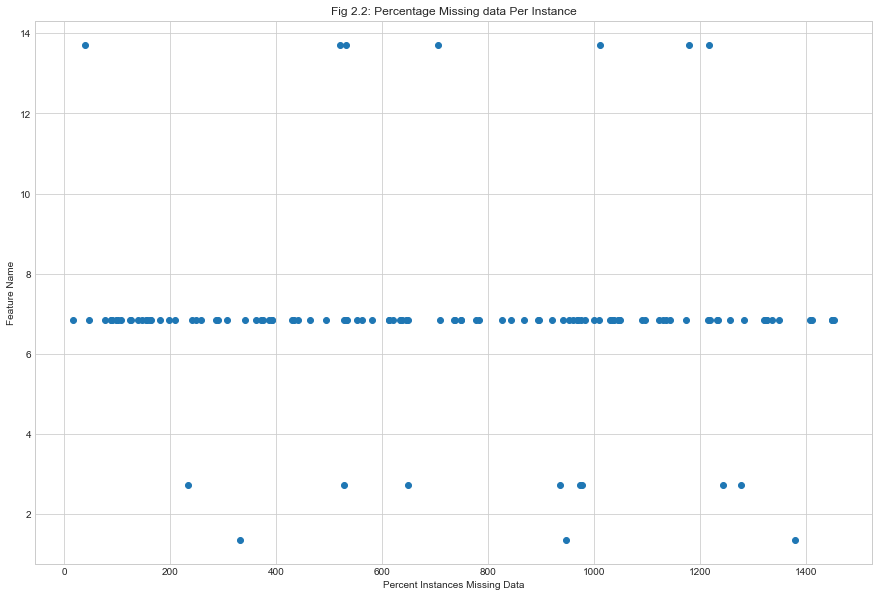

In [29]:
# checking instances with missing values 

instances_missing_data = (raw_df.isnull().sum(axis=1)/raw_df.shape[1]) * 100
instances_missing_data = instances_missing_data[instances_missing_data > 0]
instances_missing_data.sort_values(ascending=True,inplace=True)

fig,axes = plt.subplots(figsize=(15,10))
axes = plt.scatter(x=instances_missing_data.index, y =np.array(instances_missing_data) )
plt.xlabel('Percent Instances Missing Data')
plt.ylabel('Feature Name')
plt.title('Fig 2.2: Percentage Missing data Per Instance')
plt.show()

There are 7 instances missing over 10% of their data. Another 115 are missing less than 7% data. Those missing above 10 percent data will be removed and the rest will be imputted. 

In [30]:
# removing columns with too many missing values 
raw_df.drop(instances_missing_data[instances_missing_data > 10].index, axis = 0, inplace = True)

print(f"The number of features is now: {raw_df.shape[1]}")
print(f"The number of instances is now : {raw_df.shape[0]}")
print("\n\n")

The number of features is now: 73
The number of instances is now : 1453





## Imputing missing data 

The process of imputing missing data is neccessary for preserving as much data as possible, especially when we aim to use it for building models. There are several strategies that can used to impute data that vary based on the data type. The simplest methods involve imputing all missing values using the mean or the most frequent value for numeric and caterigorical data respectively. 

While this method works well, I prefer to go a step further to ensure better imputation accuracy. I use a KNN imputer that imputes missing data based on the values of closest n-neighbors. The closest neighbors are determined using a distance matrix building from the other non-null data. I believe this is a better techinique and should result in better imputations. 

For imputing purposes, the data will be separated between catergorical and numeric. This allows us to use the KNN imputer from sklearn for numeric variables and design something similar for categorical data since there is no out of the box slution. 

### Imputing numeric data 

In [31]:
# extracting numeric data
numeric_df_columns = raw_df.select_dtypes(include = ["float64", "int64"]).columns
numeric_df = raw_df[numeric_df_columns]

In [32]:
# find the number of missing data in the numeric df before imputations 
print(f"The number of missing numeric values is: {numeric_df.isnull().values.sum()}")

The number of missing numeric values is: 82


In [33]:
# imputing missing numeric data 

# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean') # nan_euclidean ignores missing values

# fit on the dataset
imputer.fit(numeric_df)

# fit on the dataset
imputer.fit(numeric_df)

# transform the dataset
numeric_df = imputer.transform(numeric_df)

#check for missing data 
print('The number of missing numeric values is now:{}\n'.format(sum(np.isnan(numeric_df).flatten())))



The number of missing numeric values is now:0



In [34]:
# turning the imputed numeric data back into a data frame from a numpy array

numeric_df = pd.DataFrame(numeric_df, columns = numeric_df_columns)
numeric_df.head()

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,HouseAge,RemodAge,GarageAge
0,8450.0,196.0,706.0,0.0,150.0,856.0,856.0,854.0,0.0,1710.0,...,61.0,0.0,0.0,0.0,0.0,0.0,208500.0,5.0,5.0,5.0
1,9600.0,0.0,978.0,0.0,284.0,1262.0,1262.0,0.0,0.0,1262.0,...,0.0,0.0,0.0,0.0,0.0,0.0,181500.0,31.0,31.0,31.0
2,11250.0,162.0,486.0,0.0,434.0,920.0,920.0,866.0,0.0,1786.0,...,42.0,0.0,0.0,0.0,0.0,0.0,223500.0,7.0,6.0,7.0
3,9550.0,0.0,216.0,0.0,540.0,756.0,961.0,756.0,0.0,1717.0,...,35.0,272.0,0.0,0.0,0.0,0.0,140000.0,91.0,36.0,8.0
4,14260.0,350.0,655.0,0.0,490.0,1145.0,1145.0,1053.0,0.0,2198.0,...,84.0,0.0,0.0,0.0,0.0,0.0,250000.0,8.0,8.0,8.0


There are no more missing values in the numerical data. 

### Imputing missing categorical data 

Inseated of just imputing all values using the most ferequent value for a featue, we will attempt to use the most frequent value for n-closest neighbours, an approach that is similar to the KNN imputer we used for the numeric/continous data. The closest neighbors will be detrmined using the numeric features. This way is better because it avoiding using categorical data inaproprietly. Others have approached a similar challenge by encoding categorical data with numeric values and using the normal kNN imputer. While I do not hold anything against such an approach, I feel that it assigns inappropriete meaning to categorical data, espeacially norminal data. 

#### Steps 

1. Extract all categorical variables
2. Find the instances with missing values
3. Use the numeric features and KDTrees to generate a matrix of ditances between intances
4. Identify the most frequent value for n-closest neighbors at the position where the target instance has a missing value
5. Impute the missing value
 

In [35]:
# extracting categorical data 
catergorical_df = raw_df[raw_df.select_dtypes(include = ["category"]).columns]
print(f"The number of missing categorical values in is: {catergorical_df.isnull().values.sum()}")

The number of missing categorical values in is: 457


In [36]:
# building a pickled KDTree using the numeric data 

X = numeric_df.to_numpy()  # will use the numeric data as an np array to calculate the distances 
tree = KDTree(X, leaf_size=2)  # becareful with the leaf_size because it affects the speed of a query and the memory required to store the constructed tree      
s = pickle.dumps(tree) # the state of the tree is saved in the pickle operation                    
tree_copy = pickle.loads(s)                


In [37]:
# extracting the initial instances with missing data  
instances_missing_data = catergorical_df.isnull().sum(axis=1)
instances_missing_data = instances_missing_data[instances_missing_data > 0]
instances_missing_data = instances_missing_data.index
instances_missing_data

# initialsing the number of neighbors to consider
number_of_nn = 7

while(len(instances_missing_data) > 0 ):

    for instance in instances_missing_data:

        # find their closest N neighbours 
        dist, ind = tree_copy.query(X[:], k=number_of_nn) # using 8 nearest neighbours 

        # get the actual index of an instance disguished by loc
        unique_index = catergorical_df.index
        actual_instance_index = unique_index.get_loc(instance)

        # find the column(s) where there is missing data  
        columns_missing_data = catergorical_df.iloc[actual_instance_index].isnull()
        columns_missing_data = columns_missing_data[columns_missing_data]
        columns_missing_data = columns_missing_data.index

        # find the most frequent value of the closest neighbours for those values 
        for column in columns_missing_data:

            current_column = [] # initializing a list to populate with values from closest neighbors

            # iterating through the nearest neightbours indeces
            for nn in ind[actual_instance_index]:
                try:
                    current_column.append(catergorical_df[column][nn])
                except:
                    continue
            # find the most frequent value for the current feature 
            most_frequent_value = max(set(current_column), key = current_column.count)

            # replace the missing value with the most frequent value in the neighbours 
            catergorical_df[column][instance] = most_frequent_value # this uses loc indexing, hence instance not actual_instance_value

    # updating the instances with missing data 
    instances_missing_data = catergorical_df.isnull().sum(axis=1)
    instances_missing_data = instances_missing_data[instances_missing_data > 0]
    instances_missing_data = instances_missing_data.index
    instances_missing_data
    
    # updating the number of neighbors to consider
    number_of_nn += 1

print(f"The number of missing categorical values in is: {catergorical_df.isnull().values.sum()}")

The number of missing categorical values in is: 0


Both numeric and categorical variables no longer have missing data. Now we can start exploring how each feature relates to the target variable. 

# Data distribution patterns

    * test the features and target variable for normalty 
    * plot them on histograms to visualize if they are normally distributed 
    * test transformations to achieve normal data 
    * visualize the results

Normality is an important assumption for many statistical techniques that can be perfomed on continous data. Therefore, it is important to check if the data meets this criteria. If not, it may be neccessary to transform the data to meet the normal distribution criteria. 

## The distribution of the target variable

We will begin our exploration by understanding the distribution of the target variable. Fistly, we will examine the skewness and kurtosis of the data and then cofirm our finding a histogram plot. 

Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point. A general guideline for skewness is that if the number is greater than +1 or lower than –1, this is an indication of a substantially skewed distribution.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. The general guideline is that if the number is greater than +1, the distribution is too peaked. Likewise, a kurtosis of less than –1 indicates a distribution that is too flat. 


Refs: 
* https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm 
* https://www.smartpls.com/documentation/functionalities/excess-kurtosis-and-skewness

In [38]:
# skewness and kurtosis 

print(f"The Skewness value of the target variable is: {numeric_df['SalePrice'].skew()}")
print(f"The Kurtosis value of the target variable is: {numeric_df['SalePrice'].kurt()}")


The Skewness value of the target variable is: 1.8950128820284293
The Kurtosis value of the target variable is: 6.585047502596432


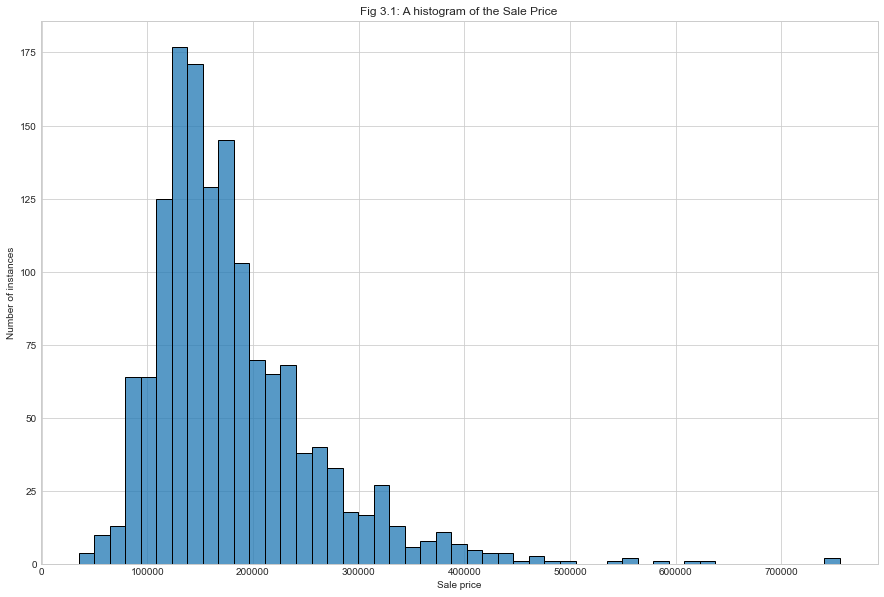

In [39]:
fig,axes = plt.subplots(figsize=(15,10))
axes = sns.histplot(numeric_df.SalePrice)
plt.xlabel('Sale price')
plt.ylabel('Number of instances')
plt.title('Fig 3.1: A histogram of the Sale Price')
plt.show()

Our target variable is evidently not normally distributed. It has high skewness and kurtosis values, indicating significant skeness to the left and strong peakeness.

The target variable will need to some transformation to become normally distributed. Two common ways to do this are:
1. the box-cox transformation
2. the johnson transformation

The box-cox transformations is relatively simple, but it has restricted applications since it only works with positive values. This is not a major concern in our case since all sale prices should be positive values. However, we can also use a more complex jonhson transformation that tends to produce superior result in most cases.  

Before settling on a transformation strategy, I always want to see the rest of the data. There are some values in the ditrubition above that do no make sense and look like outliers. Only by observing the relationship of sale price with other features can we truely determine the validity of such values and discuss how to handle them hence forth. 

## The distribution of numeric features

In [66]:
#numeric_df_columns_no_sale_price = [x for x in raw_df.columns if str(raw_df[f"{x}"].dtypes)!="category"]

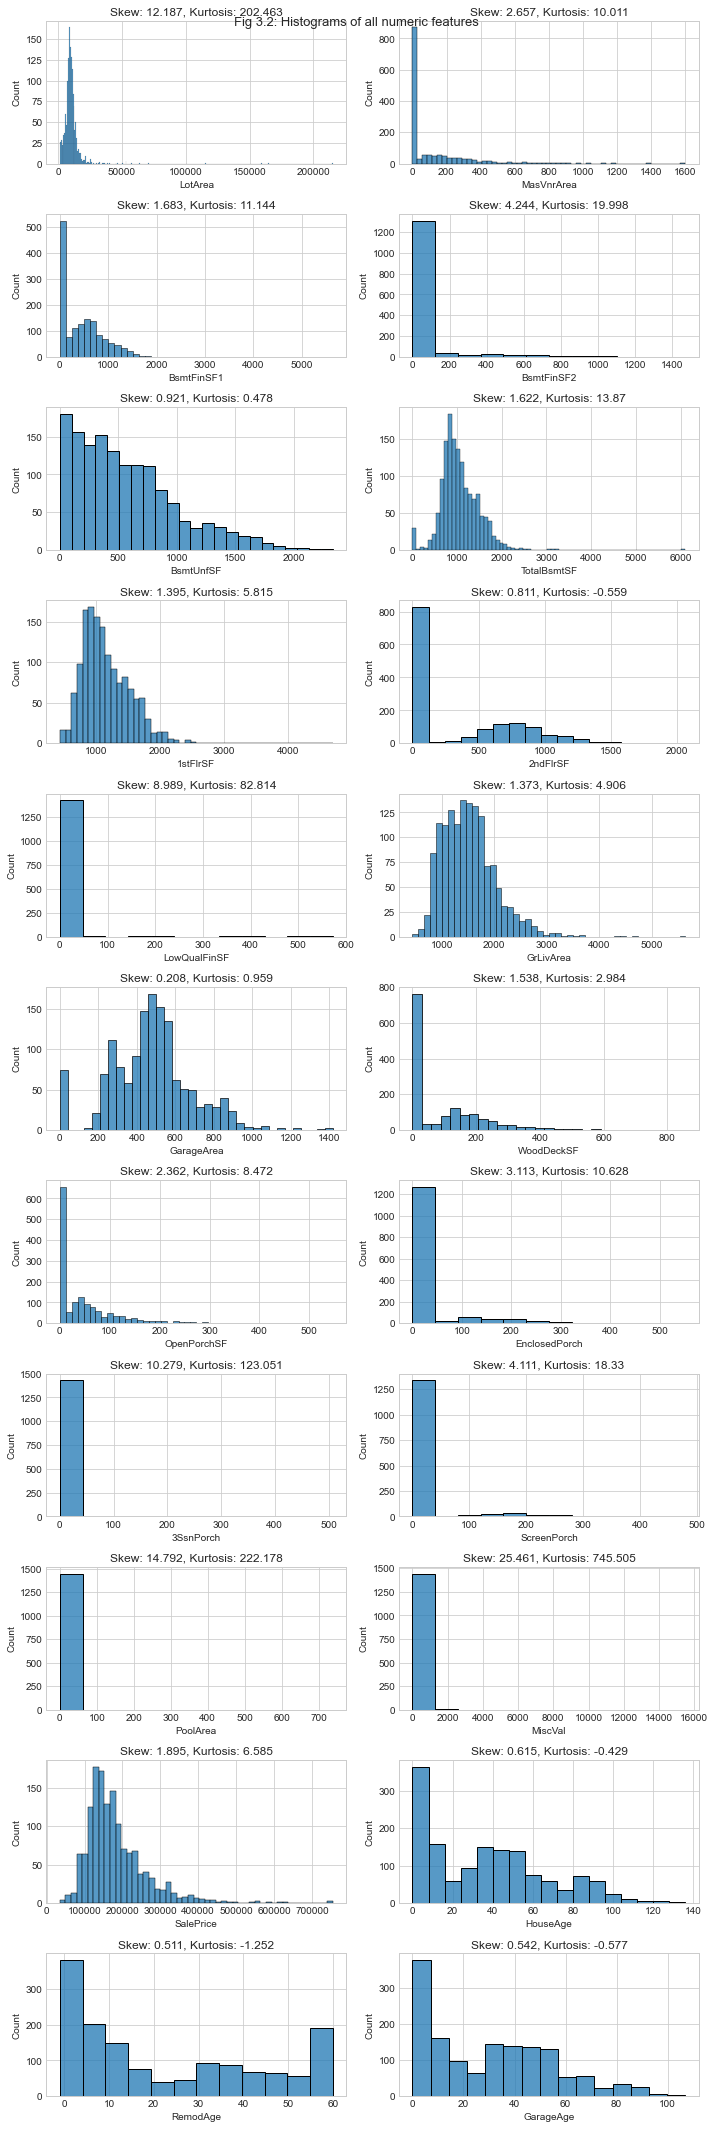

In [67]:
fig,axes = plt.subplots(11,2, figsize=(10,30))
fig.suptitle('Fig 3.2: Histograms of all numeric features', fontsize=13)

for i, ax in enumerate(axes.flatten()):
    ax = sns.histplot(numeric_df[f"{numeric_df_columns[i]}"], ax=ax)
    skew = numeric_df[f"{numeric_df_columns[i]}"].skew()
    kurt = numeric_df[f"{numeric_df_columns[i]}"].kurt()
    ax.set_title(f"Skew: {np.round(skew,3)}, Kurtosis: {np.round(kurt,3)}")

fig.subplots_adjust(top=0.99,wspace=0.2, hspace=0.3)
fig.tight_layout()
    

None of our numeric data is normally distributed. All features appear to be heavily skewed to the left and have a high kurtosis value indicating peakedness. Some of the features such as 'TotalBsmtSF', '1stFlrSF', 'GrLivArea' and 'GarageArea' appear to be closer to a normal distribution relative to the others. We should observe their relationship to the target variable to understand more about which features we would like to keep and if we will transform them. 

## The distribution of categorical features

Similar to the histrograms made for numerical variables, we will make to count plot for for the categorical variables. However, count plot for categorical variables and histograms for numeric variables do not convey the same meaning. In the case of count plots, we are searching for substantial imbalances in the data. A single category may have nearly all the values in question. This means when we finally start modellingm there will be substaintially less instances of the under-represented feature to learn from. Therefore, severe imbalances limit the predictive potential of features. 

Sometimes, you have several catefories and one that is overly dominant. It usually makes sense to group all other categories into a single category. However, this risks grouping categories with significally different relationships to the target price. Therefore, it can easily create more problems than solutions. I suggest dropping imbalanced categorical features and following the grouping approach later on to optize the model. 

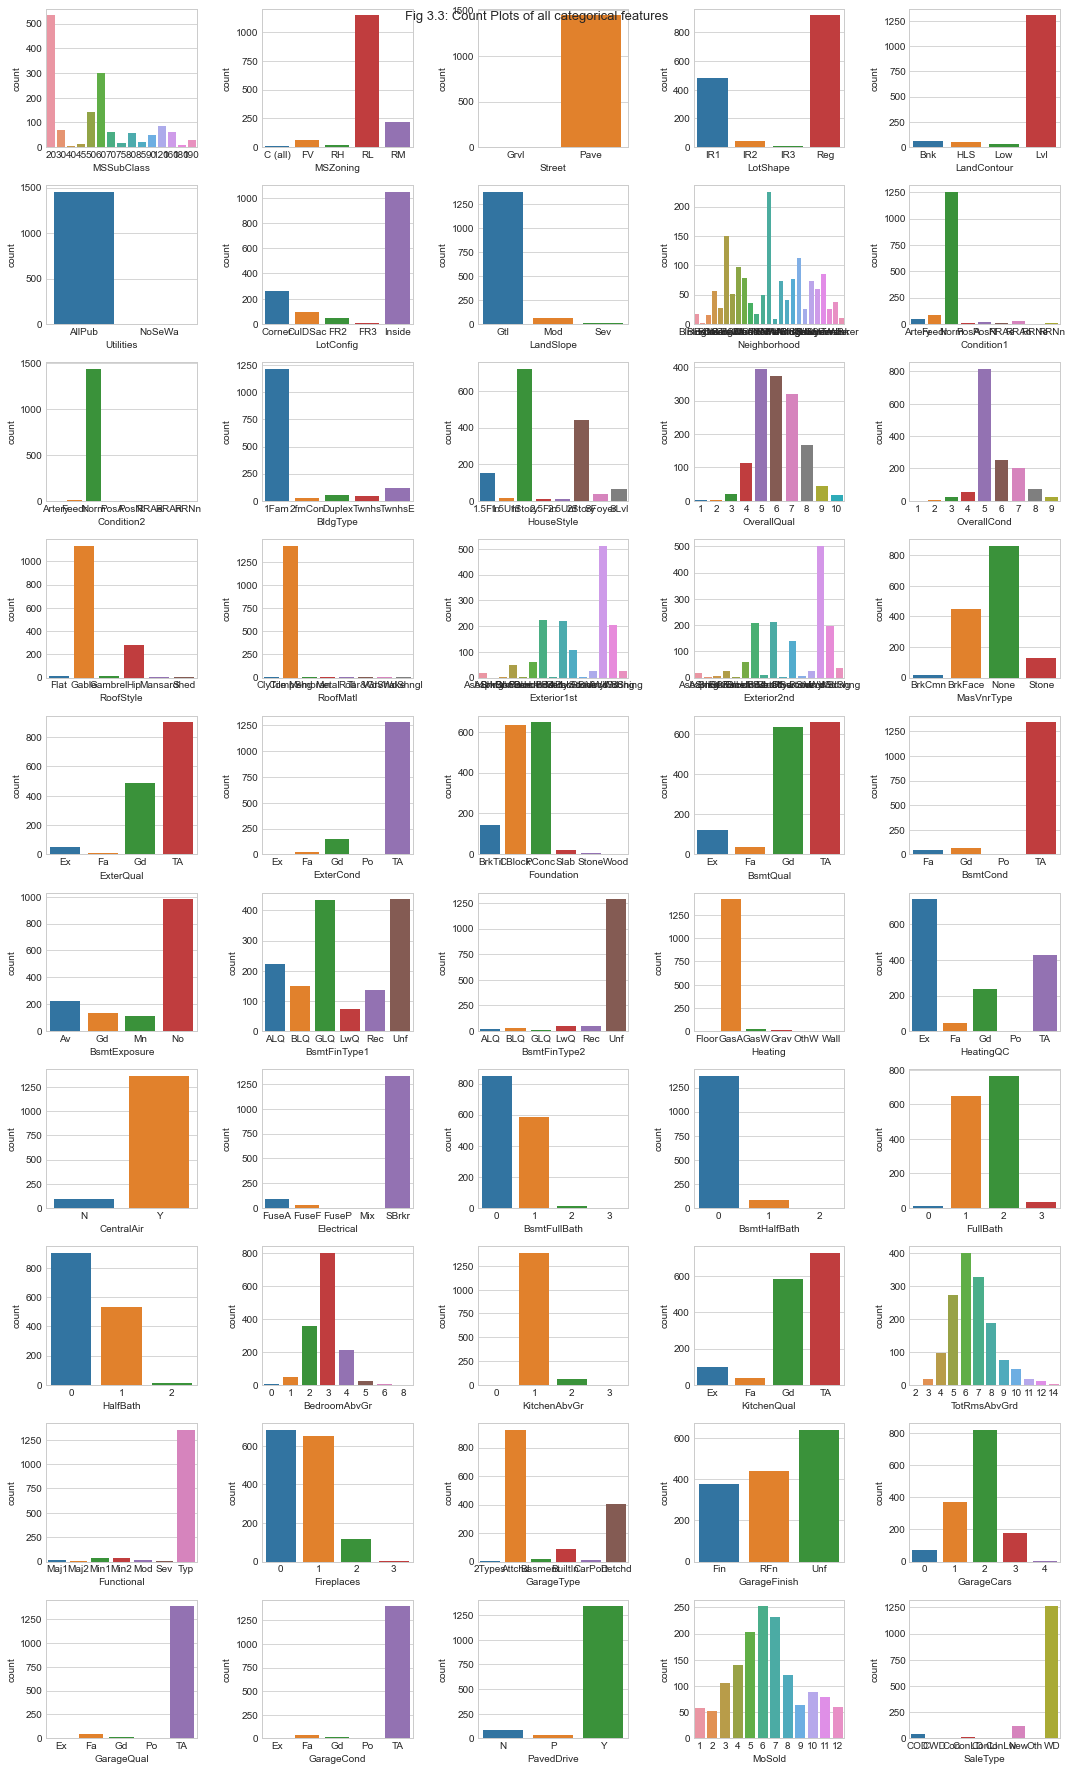

In [68]:
fig,axes = plt.subplots(10,5, figsize=(15,25))
fig.suptitle('Fig 3.3: Count Plots of all categorical features', fontsize=13)

for i, ax in enumerate(axes.flatten()):
    ax = sns.countplot(x=f"{catergorical_df.columns[i]}", data=raw_df, ax=ax)

fig.subplots_adjust(top=0.5,wspace=0.2, hspace=0.3)
fig.tight_layout()

From the figure above, I have compiled a list of somewhat balanced features. They are as follows:

* OverallQual
* OverallCond
* BsmntFinType1
* KitchenQual
* TotalRmsAbvGrd
* Fireplaces
* GuarageFinish
* GuarageCars
* MonthSold
* YearSold

The rest of the categorical features are severely imbalanced. Therefore, we will need to inspect their relationship with the target variable to determine how we will treat them. If the under-represented categories turn out to have similar relationships with the target variable, then we will group them to make a super group. If not, we will disregard the features.

# Relationships between variables

The relationship between the target variable and a feature is an important one to understand. It can vary from being a positie relationship, negative relationship or even a neutral relationship. Data modeling assumes that all features have some relationship to the target variable that we can model to make predictions. Therefore, we can identify better predictors by examining these relations. Some relationships are not apparant, especially when the data is examined in its raw form. The data may need to be transfromed for any pattern to emerge. 

## Target varible vs the numerical data 

Scatter plot provide the simplest and quickest method of examining relationships between numerial features and the target variable. Below is a plot of each numeric feature vs the target variable. 

In [69]:
# data preparation - will create a list of length 16 which has lists of the len 4, each with a turple for x and y

#main_list_numeric_feature = []

#for feature in numeric_df_columns_no_sale_price:

def getLogTransData(feature, target, df):
    """
    returns a list with 4 turples 
    index0: (raw feature array, raw target array)
    index1: (raw feature array, log10 transformed target array)
    index2: (log10 transformed feature array, raw target array)
    index3: (log10 transformed feature array, log10 transformed target array)
    """
    current_feature_list = []

    target_variable = df[f'{target}']
    feature_array = df[f'{feature}']

    # raw form
    raw_form = (feature_array, target_variable,"Both variables not transformed")
    current_feature_list.append(raw_form)

    # log10 transformed target variable
    trans_taget_var = (feature_array, np.log10(target_variable), "Target variable is log10 transformed")
    current_feature_list.append(trans_taget_var)

    # log10 transformed feature
    trans_feature = (np.log10(feature_array+1), target_variable,  "Feature variable is log10 transformed")
    current_feature_list.append(trans_feature)

    # both feature and taget log transformed
    trans_both = (np.log10(feature_array+1), np.log10(target_variable), "Both variables are log10 transformed")
    current_feature_list.append(trans_both)


    return current_feature_list

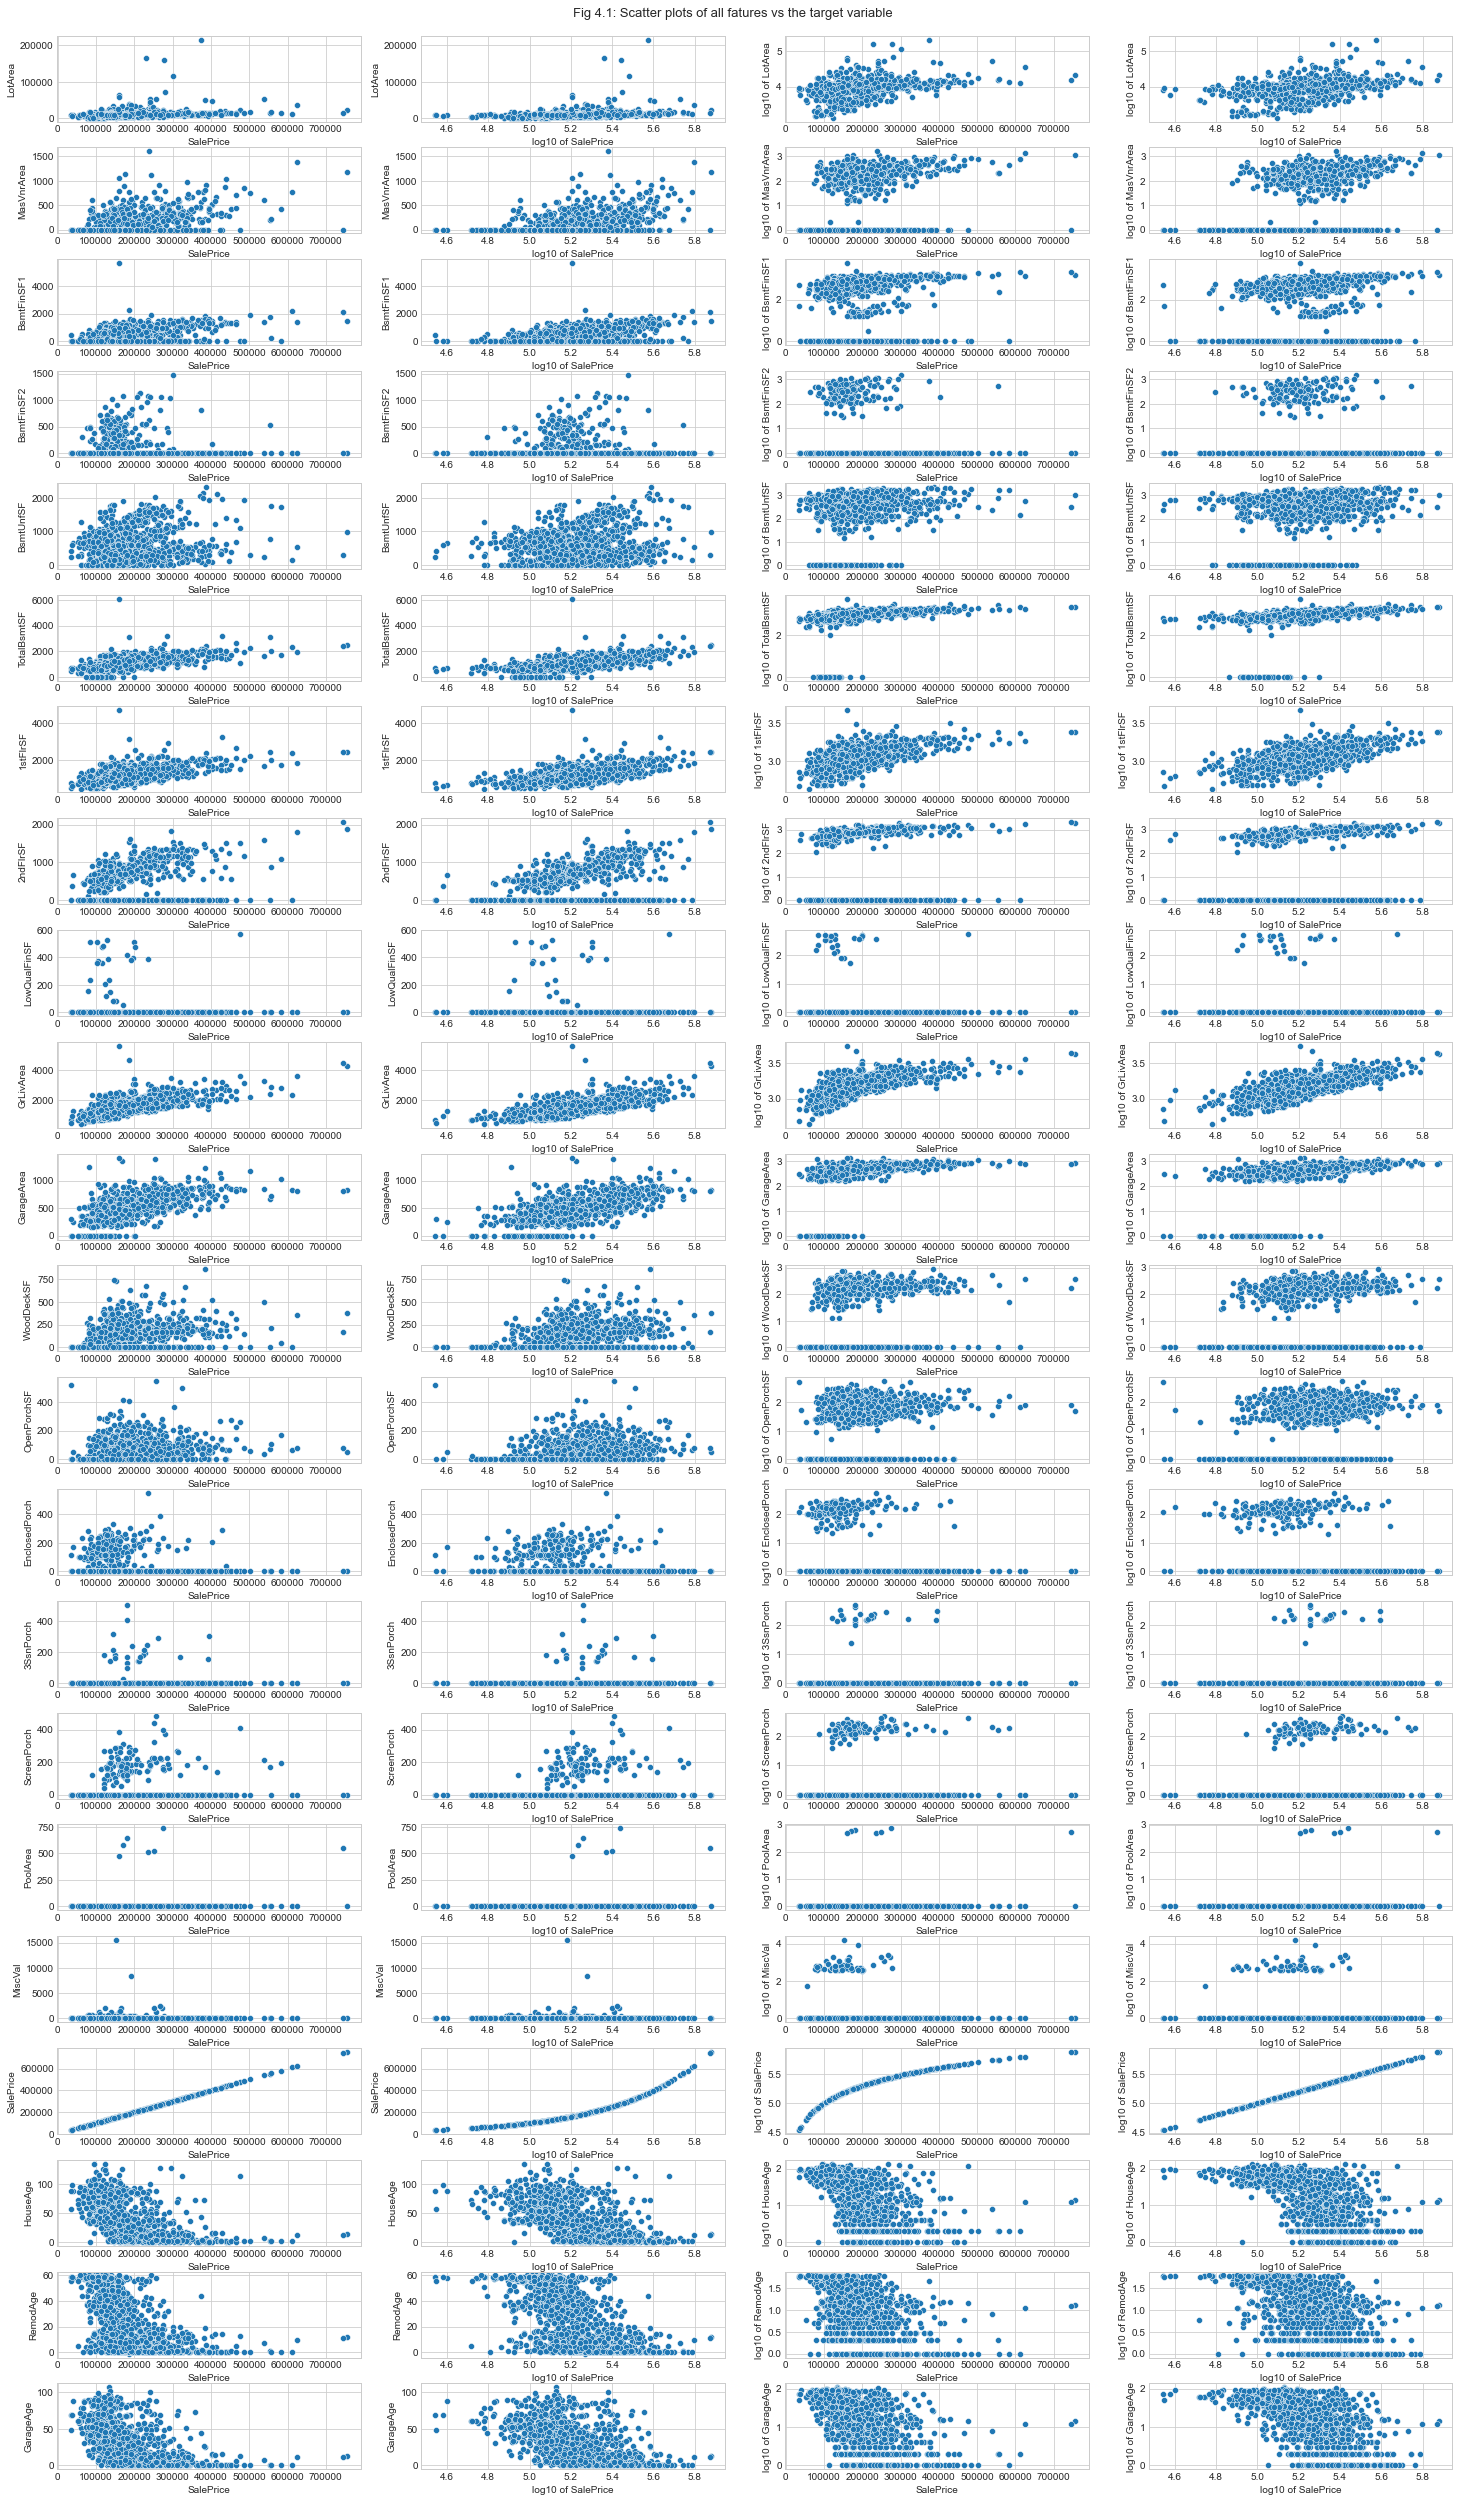

In [72]:

# defining the grid and figure size
fig, axes = plt.subplots(22, 4, figsize=(25,40), sharey=False)
fig.suptitle('Fig 4.1: Scatter plots of all fatures vs the target variable', fontsize=13)

# outer loop to iterate the classes / rows
for i in range(22):
    target = "SalePrice"
    feature = numeric_df_columns[i]
    new_feature_vectors = getLogTransData(feature=feature, target=target, df=numeric_df)
    
    # inner loop to populate the columns in each row
    for j in range(4):
        feature_vector = new_feature_vectors[j][0]
        target_vector = new_feature_vectors[j][1]
        label = new_feature_vectors[j][2]
        axes[i][j] = sns.scatterplot(y=feature_vector,x=target_vector,  ax=axes[i][j])
        
        if j == 1 :
            axes[i][j].set_xlabel(f"log10 of {target}")
        elif j == 2: 
            axes[i][j].set_ylabel(f"log10 of {feature}")
        elif j == 3: 
            axes[i][j].set_xlabel(f"log10 of {target}")
            axes[i][j].set_ylabel(f"log10 of {feature}")
        
fig.subplots_adjust(top =0.97,wspace=0.2, hspace=0.3)    
plt.show()

Fig 4.1 shows scatter plots of all numeric/continous variables against the target variable. The first row of graphs contain scatter plots generated from raw data. The second row contains scatter plots enerated from raw data for the numeric variable and a log transformed target variable. The third row contains scatter plots generated from a log transformed numeric feature and a raw value for the target variable. The fourth row contains scatter plots for log transformed numeric variabls and log transformed target variable. 

These visualizations generated to explore the relationship with the target variable and the numeric features. Various versions of the graphs were generated to ensure that the major common linear realtionships can be captured. It appears that TotalBsmntSF, 1stFlrSF, 2ndFlrSF, GrLivArea, GuarageArea, HouseAge have some linear relationship to the target variables. We will measure the strenght of these relaitionships using a correlation matrix. 
    

### Correlation Matrix of the numeric data

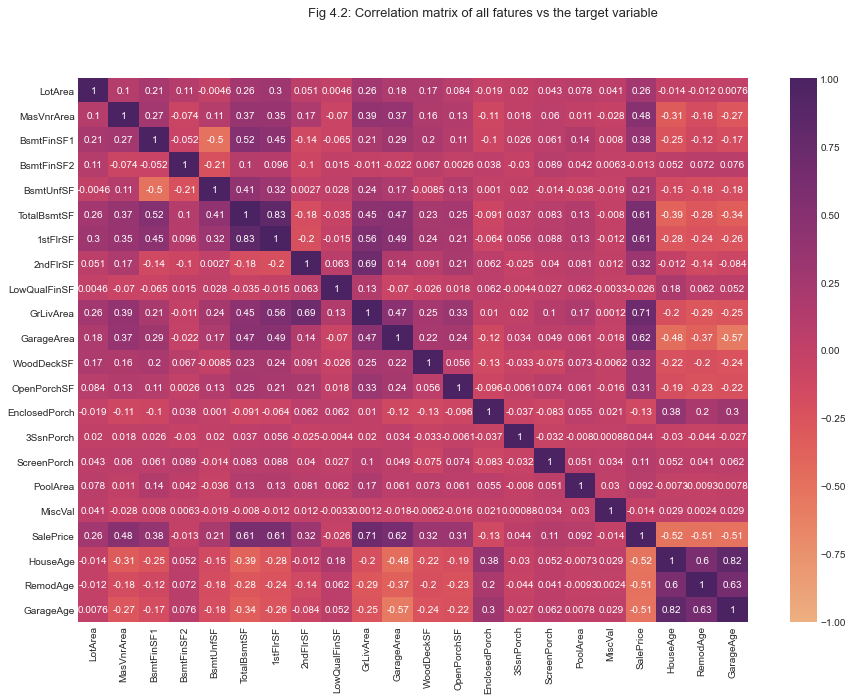

In [75]:
corr = numeric_df.corr()# calulating a correlation matrix of the data

# plotting the correlation matrix in a heatmap
fig, ax = plt.subplots(figsize=(15, 10))
fig.suptitle('Fig 4.2: Correlation matrix of all fatures vs the target variable', fontsize=13)


ax = sns.heatmap(corr, 
                 vmin=-1, 
                 vmax=1,
                 annot=True,
                 cmap = "flare")


Fig 4.2 shows a correlation matrix of all the numeric features. The threshold of the correlation value that is acceptable differs depending on domain and other factors. For our purposes, we will select features with at least 0.3 or less than -0.3 correlation value. These are :

* MasVnrArea
* BsmntFinSF1
* TotalBsmntSF
* 1stFlrSF
* GrLivArea
* GarageArea
* WoodDeckSF
* OpenPorchSF
* HouseAge
* RemodAge
* GarageAge 

Fig 4.2 also shows us that there is colinearity between HouseAge, RemodAge and GarageAge. It makes sense that most garages are built together with house and this can also be seen in Fig 4.1. Howevr, the remodeling age is particularly interesting. not all houses will have remodels done to them. While it is related to the house age, it not strngly correlated. Therefore we should keep it. 

## Target variable vs categorical data

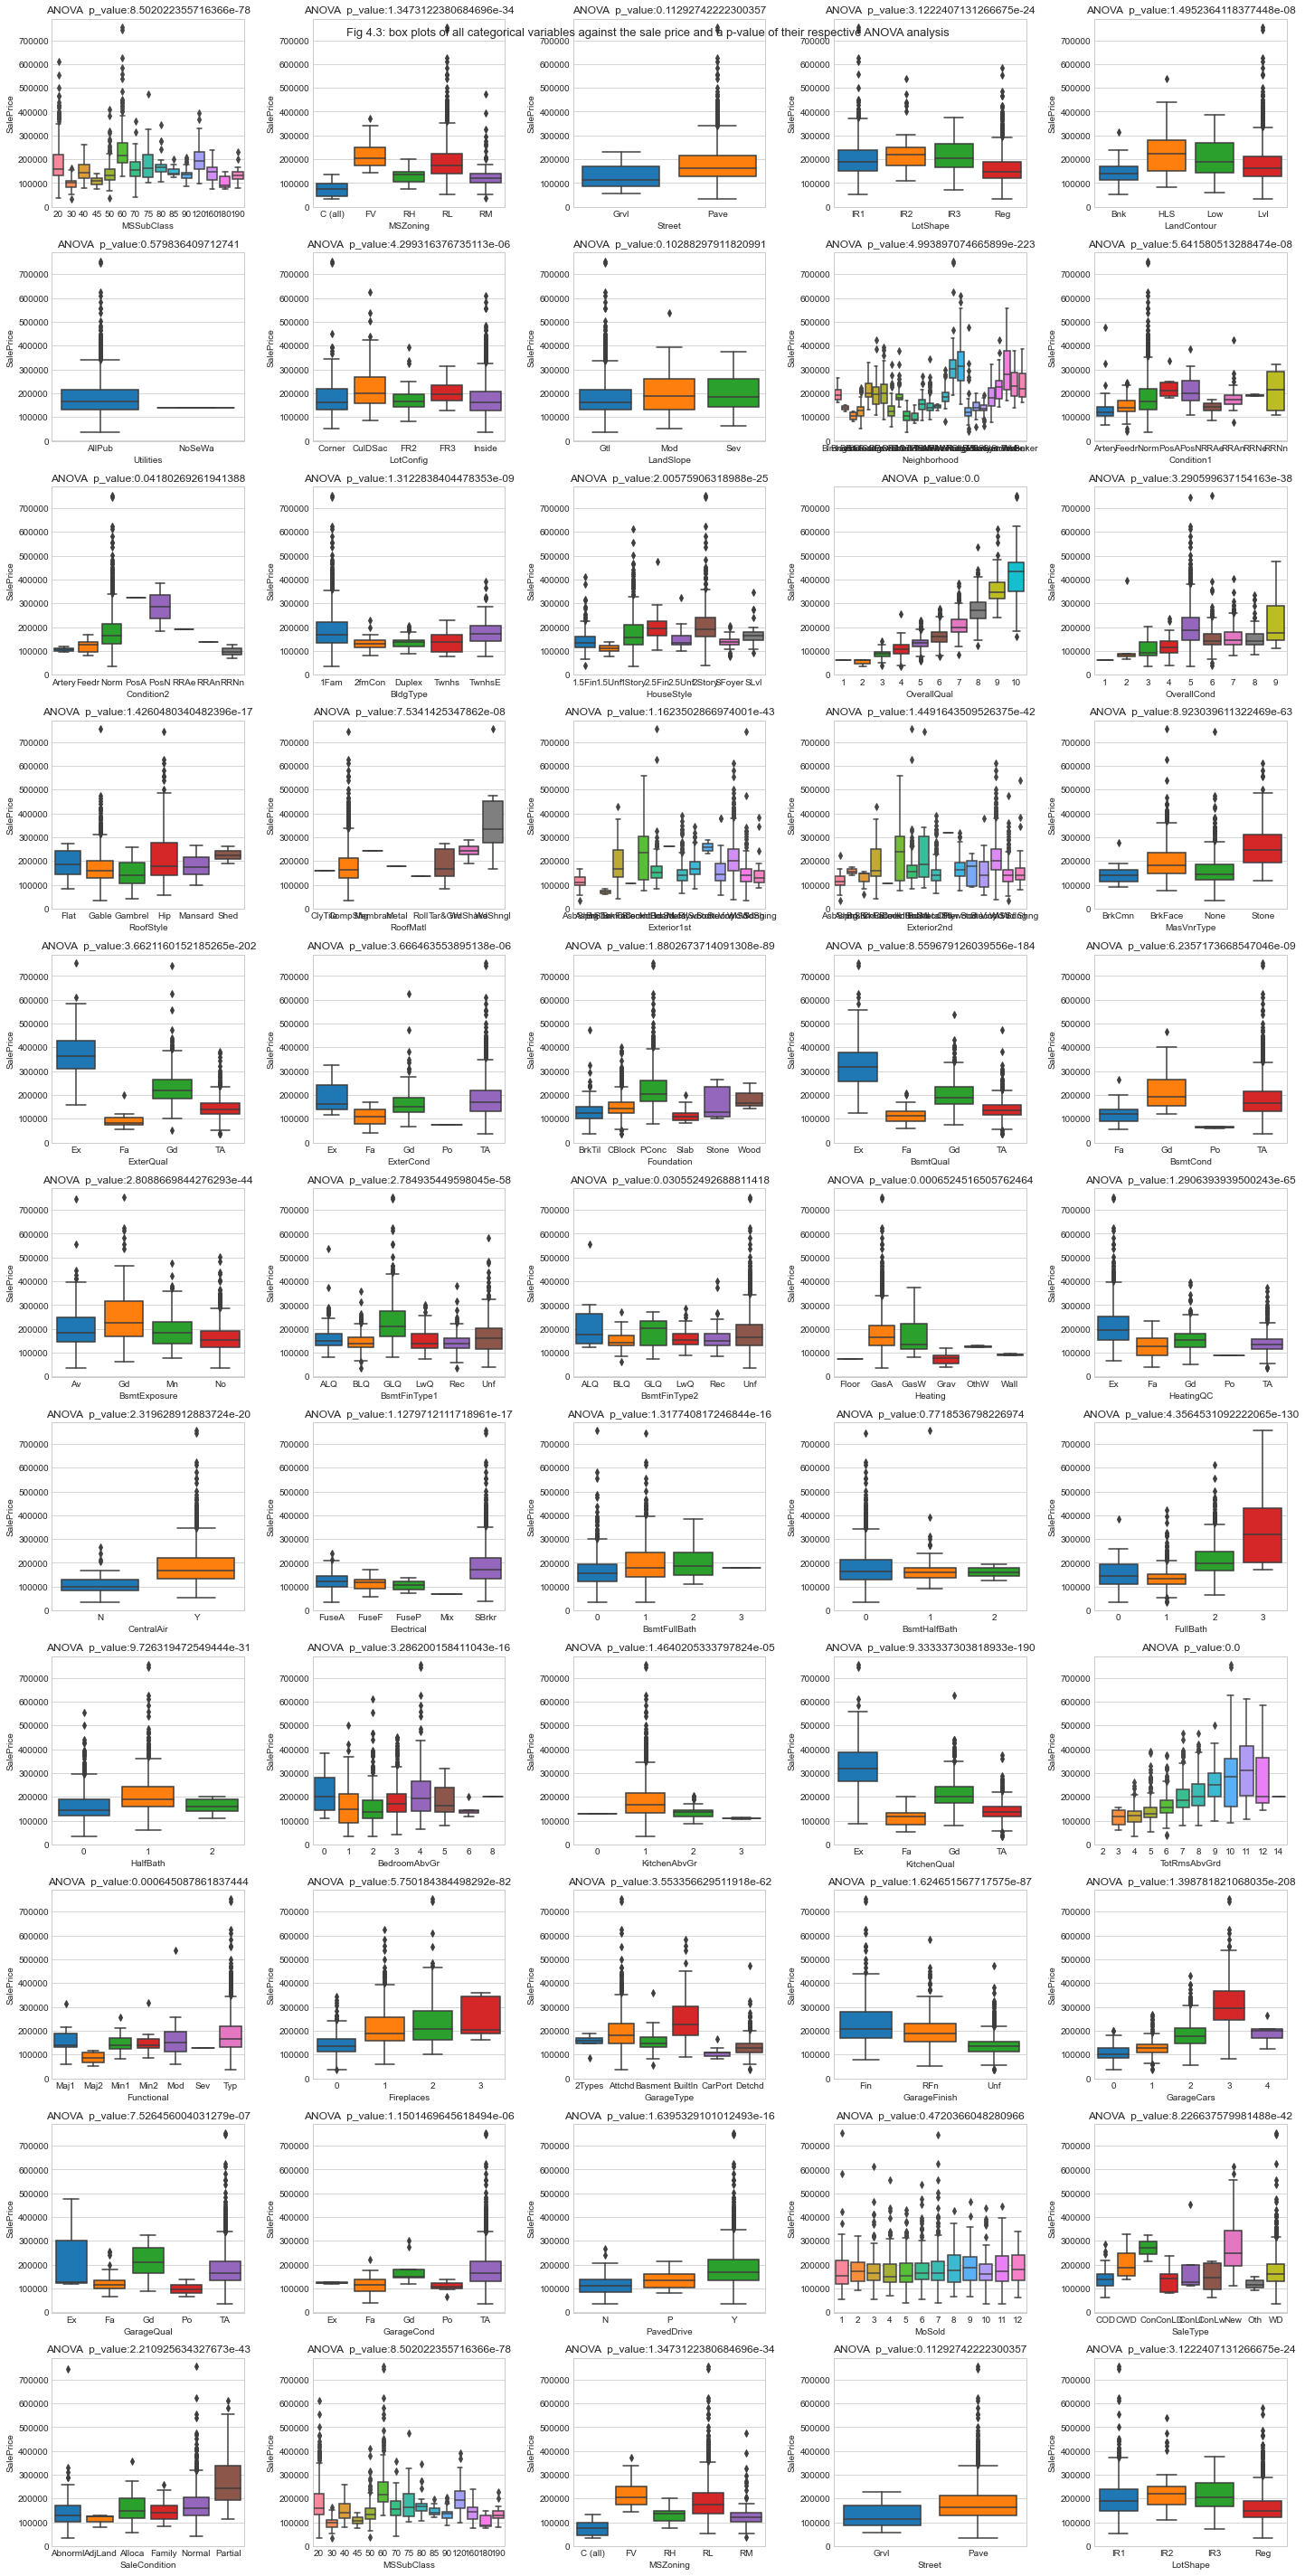

In [100]:
catergorical_with_saleprice_df = catergorical_df
catergorical_with_saleprice_df["SalePrice"] = raw_df.SalePrice


fig,axes = plt.subplots(11,5, figsize=(20,40))
fig.suptitle('Fig 4.3: box plots of all categorical variables against the sale price and a p-value of their respective ANOVA analysis', fontsize=13)

for i, ax in enumerate(axes.flatten()):
    if i > 50:
        i=i-51
        
    # anoa analysis to see if there are differences between the means 
    res = stat()

    res.anova_stat(df=catergorical_with_saleprice_df, res_var='SalePrice', anova_model=f'SalePrice ~ {catergorical_df.columns[i]}')
    p_value = res.anova_summary["PR(>F)"][0]
    
    
    ax = sns.boxplot(x=f"{catergorical_df.columns[i]}", y="SalePrice", data=raw_df,saturation=1, ax=ax)
    ax.set_title(f"ANOVA  p_value:{p_value}")

fig.subplots_adjust(wspace=0.2, hspace=0.3, top =10)
fig.tight_layout()
    

Fig 4.3 shows box plots of all categorical variables against the sale price. We included an anova p_value to the graphs to facilitate our understanding of the distribution of the features relative to the sale price. The anova analysis helps to test if the mean sale price of various groups within an categorical feature are the same. If they are, then that feature has less predictive potential since the two groups are difficult to separate. 

According to the ANOVA analysis, the groups within the following features are not statistically different using a threshold value of 0.05:
* Street
* MoSold
* BsmntHalfBath
* Utilities
* LandSlope

These features should be removed when uilding machine learning models. 

ANOVA helped us identify the features with at least two groups whose difference between their means is statistically significant. To identify wich groups have different means and potentially groups the ones with means that are not statistically different, we will need to use the Tukey’s HSD test. For now, we will only use the ANOVA results. 


# Conclusion 

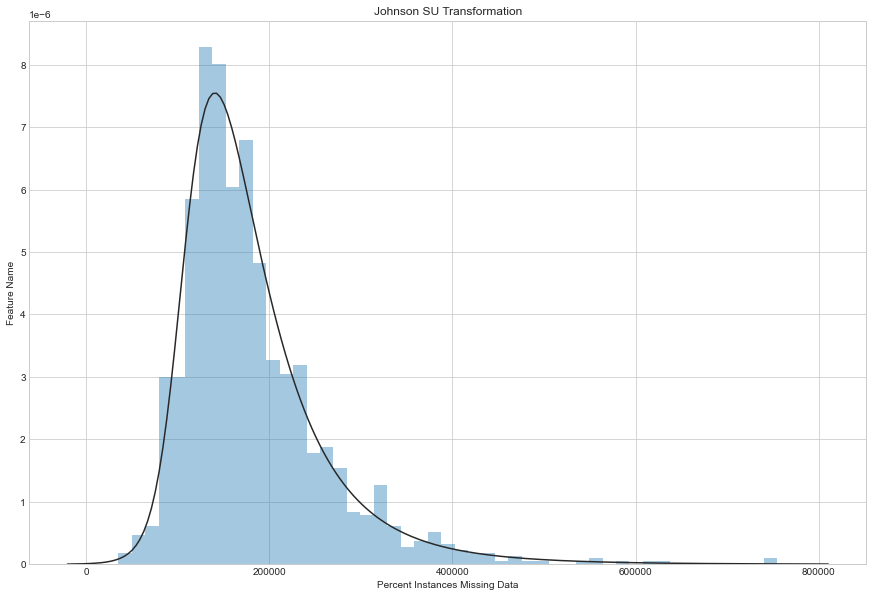

In [66]:


fig,axes = plt.subplots(4,4, figsize=(15,10))
axes = sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.xlabel('Percent Instances Missing Data')
plt.ylabel('Feature Name')
plt.title('Johnson SU Transformation')
plt.show()

### Testing Normality in  the numeric variables 

Aside from skewness and kurtosis, we can also use the Shapiro-Wilk test to assess if our data comes from a normal distribution. The test gives a W value; small values indicate the sample is not normally distributed (there is evidence to reject the null hypothesis that your population is normally distributed if your values are under a certain threshold)

In [45]:
# testing for normality using the Shapiro-Wilk test
#Aside from skewness and kurtosis, we can also use the Shapiro-Wilk test to assess if our data comes from a normal distribution. The test gives a W value; small values indicate the sample is not normally distributed (there is evidence to reject the null hypothesis that your population is normally distributed if your values are under a certain threshold)
test_normality = lambda x: stats.shapiro(x)[1] < 0.01
normal = numeric_df.apply(test_normality)
print(not normal.any())

False


According the the Shapiro-Wilk test, all our features are not normally distributed. Therefore, they all need some transformation to become normally distributed. 

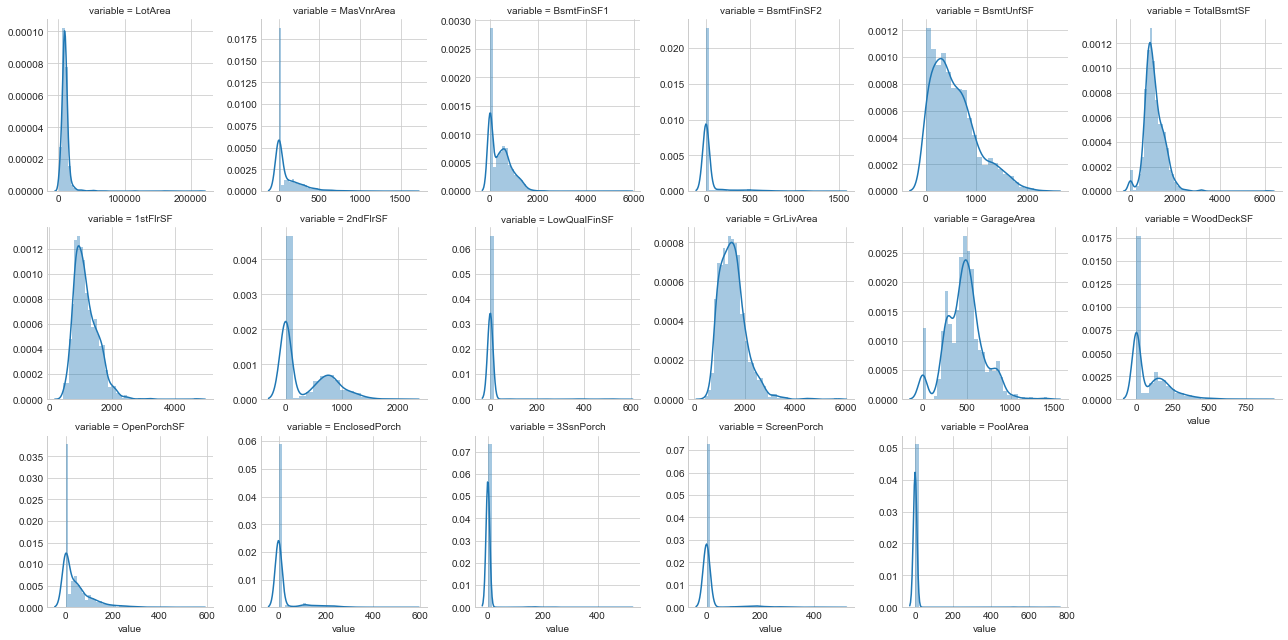

In [62]:
# visualizing the distribution of the rest of the numeric data 

fig = pd.melt(numeric_df, value_vars=[x for x in numeric_df_columns[:len(numeric_df_columns)-2]]) # excluding Sale Price
axes = sns.FacetGrid(fig, col="variable",  col_wrap=6, sharex=False, sharey=False)
axes = axes.map(sns.distplot, "value")

 The graphs above depict the distribution of our features. It is evident that most of them are severely skewed. 

### Transforming all the numeric data data using johnson transformation

NB: this section may be removed. Dont need to transform before splitting trains and test sets


For ease of emplementation, we will transform the numeric data using a variation of the johnson transformation called Yeo-Jonhson transformation. It can be can be thought of as an extension of the Box-Cox transformation. It handles both positive and negative values, whereas the Box-Cox transformation only handles positive values. Both can be used to transform the data so as to improve normality.

Ref:
https://feature-engine.readthedocs.io/en/latest/transformation/YeoJohnsonTransformer.html

In [69]:
from feature_engine import transformation as vt

# to install : conda install -c conda-forge feature_engine

In [80]:
# set up the variable transformer
tf = vt.johnsonsuTransformer(variables = list(numeric_df_columns))

# fit the transformer
tf.fit(numeric_df)

# transform the data
transformed_numeric_df= tf.transform(numeric_df)

AttributeError: module 'feature_engine.transformation' has no attribute 'johnsonsuTransformer'

In [74]:
transformed_numeric_df

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,10.477368,3.066051,15.525553,-0.000000,20.624171,183.209688,4.332062,4.529348,-0.0,6.504387,208.078603,-0.000000,4.247515,-0.000000,-0.0,-0.0,-0.0,-0.000000,0.222991
1,10.647838,-0.000000,17.088935,-0.000000,28.606156,243.144776,4.475786,-0.000000,-0.0,6.272821,180.313442,4.634217,0.000000,-0.000000,-0.0,-0.0,-0.0,-0.000000,0.222991
2,10.860707,3.008231,13.875113,-0.000000,35.418791,193.105063,4.359360,4.535244,-0.0,6.537323,226.532240,-0.000000,3.861009,-0.000000,-0.0,-0.0,-0.0,-0.000000,0.222991
3,10.640848,-0.000000,10.753145,-0.000000,39.503126,167.328891,4.375732,4.477402,-0.0,6.507483,236.838367,-0.000000,3.674046,0.699892,-0.0,-0.0,-0.0,-0.000000,0.222991
4,11.180928,3.227625,15.182443,-0.000000,37.634676,226.503035,4.440503,4.616774,-0.0,6.693822,293.882768,4.344562,4.582347,-0.000000,-0.0,-0.0,-0.0,-0.000000,0.222991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,10.390588,-0.000000,0.000000,-0.000000,52.331877,198.133099,4.372600,4.440456,-0.0,6.475912,180.313442,-0.000000,3.810848,-0.000000,-0.0,-0.0,-0.0,-0.000000,0.222991
1449,11.073774,2.909297,16.051412,0.660154,41.247915,281.352336,4.648370,-0.000000,-0.0,6.649797,193.045653,4.736111,0.000000,-0.000000,-0.0,-0.0,-0.0,-0.000000,0.222991
1450,10.567748,-0.000000,11.621265,-0.000000,50.232385,227.511433,4.453930,4.653575,-0.0,6.740788,110.124330,-0.000000,4.230299,-0.000000,-0.0,-0.0,-0.0,0.228964,0.222991
1451,10.664059,-0.000000,6.391547,0.660428,0.000000,216.763500,4.418391,-0.000000,-0.0,6.151688,105.802563,4.766560,0.000000,0.699306,-0.0,-0.0,-0.0,-0.000000,0.222991


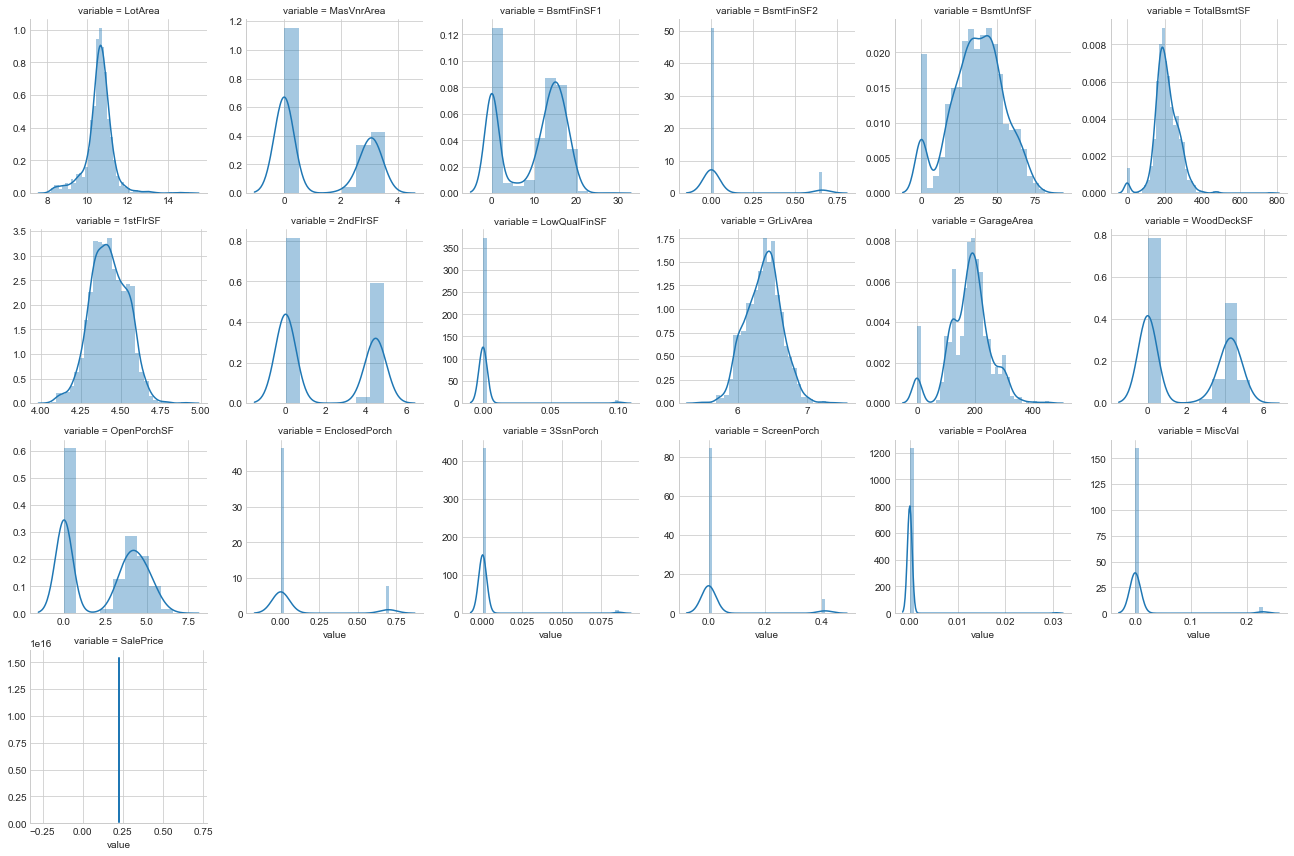

In [77]:
# visualizing the transformed data 

fig = pd.melt(transformed_numeric_df, value_vars=transformed_numeric_df) # excluding Sale Price
axes = sns.FacetGrid(fig, col="variable",  col_wrap=6, sharex=False, sharey=False)
axes = axes.map(sns.distplot, "value")

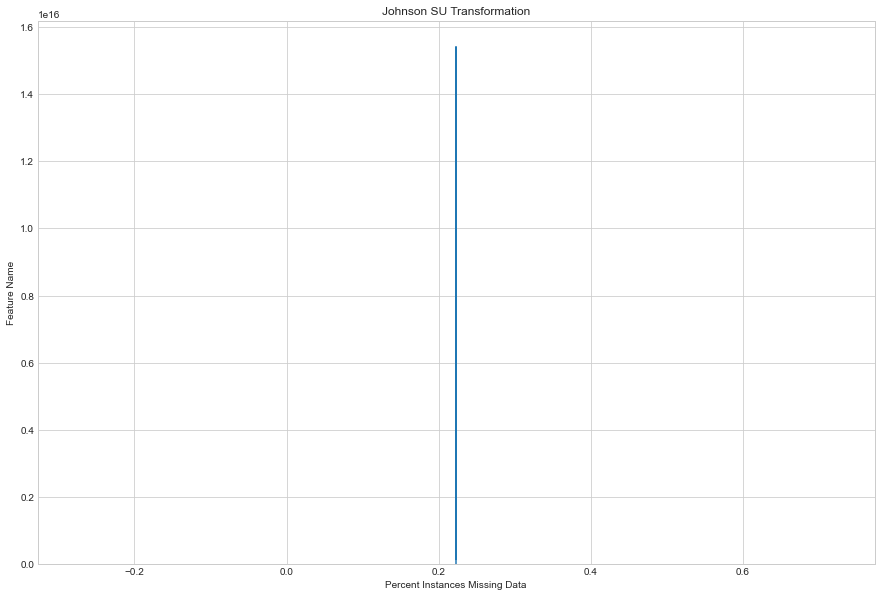

In [79]:
fig,axes = plt.subplots(figsize=(15,10))
axes = sns.distplot(transformed_numeric_df['SalePrice'])
plt.xlabel('Percent Instances Missing Data')
plt.ylabel('Feature Name')
plt.title('Johnson SU Transformation')
plt.show()

## Data correlations 
    * examine the correlation of each feature with the target variable 
    * examine the multicolinearity between features 
        * can also use pairplots 
    * suggests solutions to the challenges that are observed
    